In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

2022-09-15 15:08:51.080393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 15:08:51.227636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 15:08:51.228396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 15:08:51.230070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510], dtype=int32)>

In [2]:
# Opening the dataframe and setting the index
Univariate_data = pd.read_csv('../input/univariate/Univariate_Labeled.csv', parse_dates=['DateTime'])
Univariate_data['DayOfWeek'] = Univariate_data['DateTime'].dt.day_of_week # Introducing the day of the week
Univariate_data.drop(columns='DateTime', inplace=True) # Removing DateTime (we have the day of the week)
Univariate_data = Univariate_data[0:34944] # 52 weeks
Univariate_data

,Consumption,Anomaly,DayOfWeek
0,950.0,0,2
1,939.0,0,2
2,943.0,0,2
3,971.0,0,2
4,1014.0,0,2
...,...,...,...
34939,886.0,0,1
34940,883.0,0,1
34941,868.0,0,1
34942,872.0,0,1


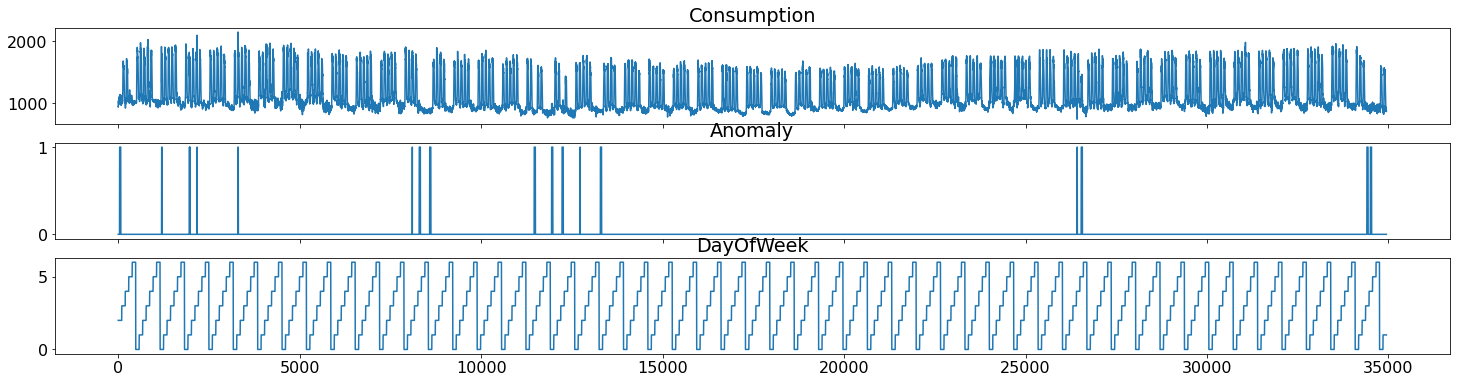

In [3]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [4]:
# Columns used for the following split in train, test and validation sets
Univariate_data['Test'] = 0
Univariate_data['Validation'] = 0
Univariate_data['Train_P1'] = 0
Univariate_data['Train_P2'] = 0
Univariate_data['Train_P3'] = 0
Univariate_data

,Consumption,Anomaly,DayOfWeek,Test,Validation,Train_P1,Train_P2,Train_P3
0,950.0,0,2,0,0,0,0,0
1,939.0,0,2,0,0,0,0,0
2,943.0,0,2,0,0,0,0,0
3,971.0,0,2,0,0,0,0,0
4,1014.0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34939,886.0,0,1,0,0,0,0,0
34940,883.0,0,1,0,0,0,0,0
34941,868.0,0,1,0,0,0,0,0
34942,872.0,0,1,0,0,0,0,0


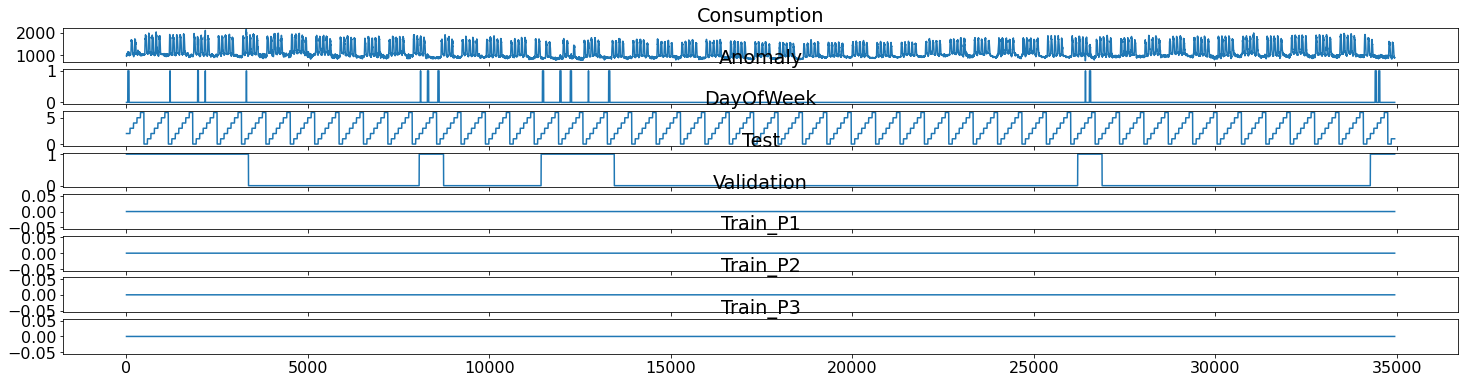

In [5]:
# TEST SET

# Weeks containing anomalies
for i in range (52):
    Slice_Univariate_data = Univariate_data.iloc[(i)*672:(i+1)*672]
    if(Slice_Univariate_data['Anomaly'].sum() != 0):
        for k in range (i*672, (i+1)*672):
            Univariate_data.at[k, 'Test'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

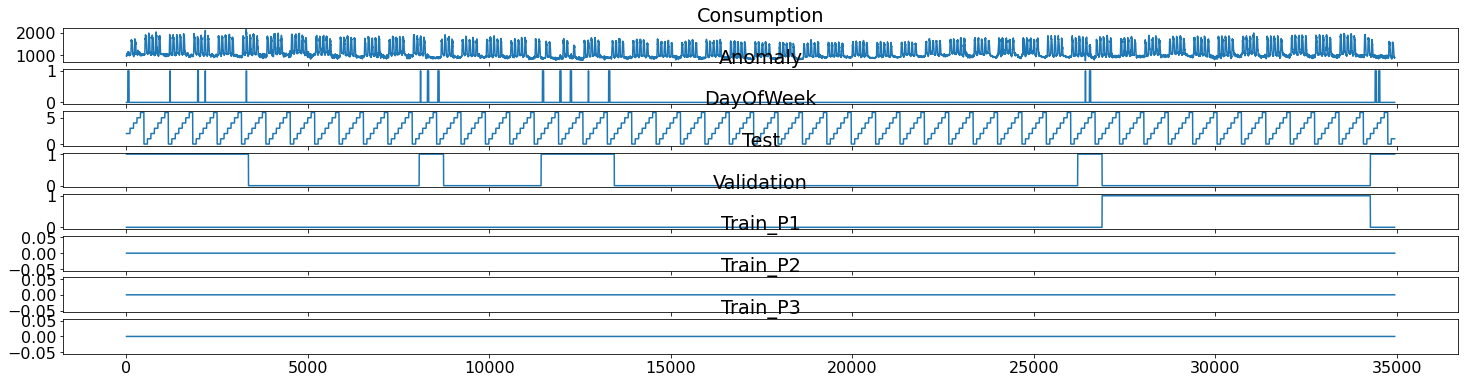

In [6]:
# VALIDATION SET

# Some random weeks
week = [40,41,42,43,44,45,46,47,48,49,50]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Validation'] = 1
        
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [7]:
# TRAINING SET

week = [5,6,7,8,9,10,11]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P1'] = 1
    
week = [13,14,15,16]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P2'] = 1
    
week = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    for k in range ((j)*672, (j+1)*672):
        Univariate_data.at[k,'Train_P3'] = 1

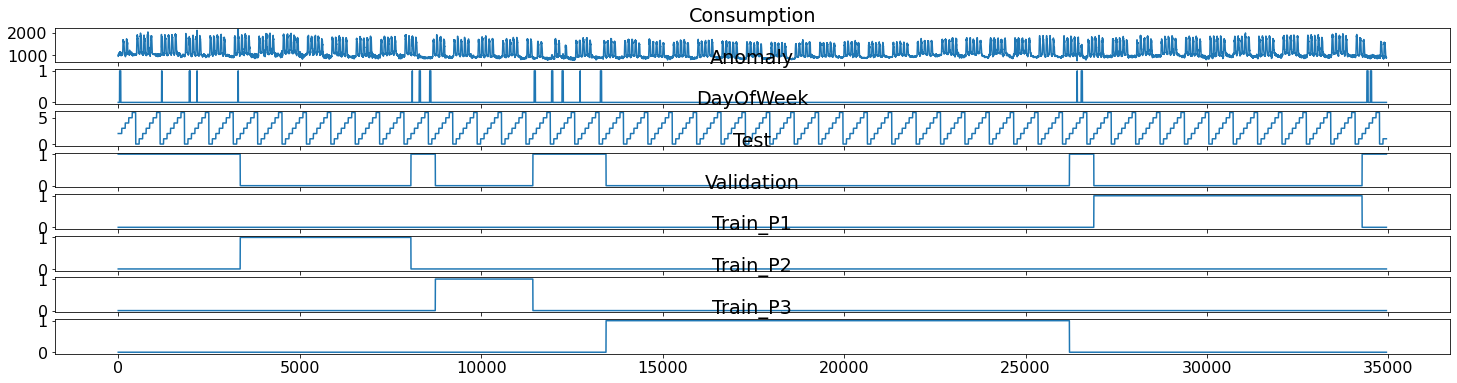

In [8]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [9]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = Univariate_data[Univariate_data['Train_P1']==1].copy()
X_train_temp_P2 = Univariate_data[Univariate_data['Train_P2']==1].copy()
X_train_temp_P3 = Univariate_data[Univariate_data['Train_P3']==1].copy()
X_validation_temp = Univariate_data[Univariate_data['Validation']==1].copy()
X_test_temp = Univariate_data[Univariate_data['Test']==1].copy()

In [10]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly']]
Anomaly_Train_P3 = X_train_temp_P3[['Anomaly']]
Anomaly_Validation = X_validation_temp[['Anomaly']]
Anomaly_Test = X_test_temp[['Anomaly']]

In [11]:
temp = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global = pd.concat([X_train_temp_P3,temp],axis=0)
X_train_temp_global.shape

(20160, 8)

In [12]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_train_raw_P3 = (X_train_temp_P3-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0]+X_train_raw_P3.shape[0] == Univariate_data.shape[0])

Consumption    1136.788542
Anomaly           0.000000
DayOfWeek         3.000000
Test              0.000000
Validation        0.000000
Train_P1          0.233333
Train_P2          0.133333
Train_P3          0.633333
dtype: float64 Consumption    282.830237
Anomaly          0.000000
DayOfWeek        2.000050
Test             0.000000
Validation       0.000000
Train_P1         0.422963
Train_P2         0.339943
Train_P3         0.481906
dtype: float64
True


In [13]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['Consumption', 'DayOfWeek']]
X_train_raw_P2 = X_train_raw_P2[['Consumption', 'DayOfWeek']]
X_train_raw_P3 = X_train_raw_P3[['Consumption', 'DayOfWeek']]
X_validation_raw = X_validation_raw[['Consumption', 'DayOfWeek']]
X_test_raw = X_test_raw[['Consumption', 'DayOfWeek']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_train_raw_P3.shape, X_validation_raw.shape, X_test_raw.shape

((4704, 2), (2688, 2), (12768, 2), (7392, 2), (7392, 2))

In [14]:
X_train_raw_P1.reset_index(inplace=True)
X_train_raw_P1.drop(columns='index', inplace=True)
X_train_raw_P2.reset_index(inplace=True)
X_train_raw_P2.drop(columns='index', inplace=True)
X_train_raw_P3.reset_index(inplace=True)
X_train_raw_P3.drop(columns='index', inplace=True)
X_validation_raw.reset_index(inplace=True)
X_validation_raw.drop(columns='index', inplace=True)
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)

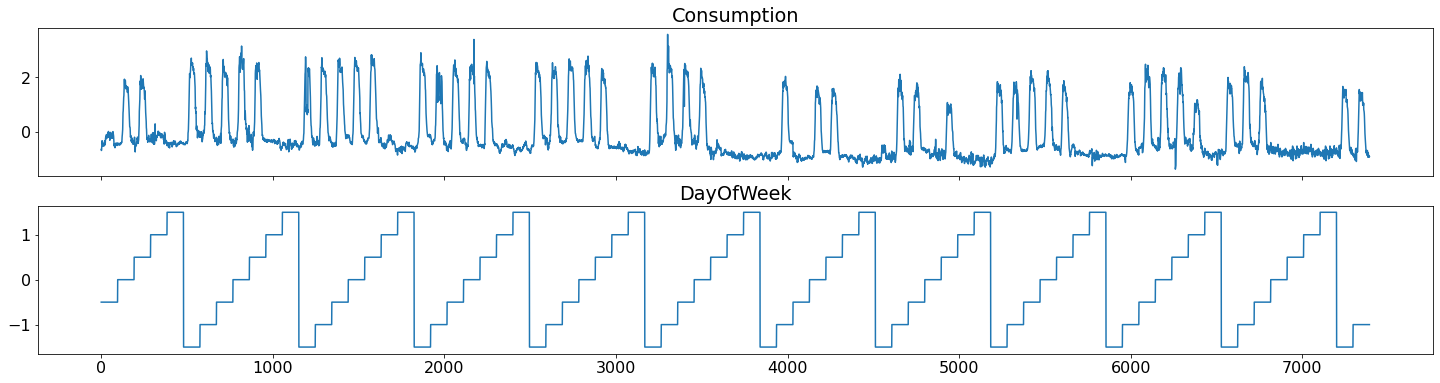

In [15]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training - Preparation

In [16]:
# Training parameters

window = 672       # 1 week
stride = 4         # 1 hour
latent_dim = 10    # Latent dimension - lat_dim = 16 is better !!!
epochs = 500       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
M = 200            # Montecarlo
alpha = 0.5
noise_factor = [0.1, 0.1]

In [17]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [18]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_train_P3, A_train_P3 = build_sequences(X_train_raw_P3, Anomaly_Train_P3, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape,X_train_P3.shape

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1009, 672, 2), (505, 672, 2), (3025, 672, 2))

In [19]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
X_train = np.concatenate([X_train,X_train_P3],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
A_train = np.concatenate([A_train,A_train_P3],axis=0)
X_train.shape, A_train.shape

((4539, 672, 2), (4539, 672, 1))

In [20]:
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=window) 
X_test.shape

PADDING: 0


(11, 672, 2)

## Building the model + Training

In [21]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [22]:
# Reparametrization trick
def sample_z1(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

# Reparametrization trick
def sample_z2(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [23]:
class AddNoise(tfk.layers.Layer):
    
    def call(self, inputs):
        data, noise_factor = inputs
        noise = tf.map_fn(fn=lambda t: tf.random.normal((672,2), 0, 1)*noise_factor, elems=data)
        noise_input = data + noise
        
        return noise_input

In [24]:
class SimScore(tfk.layers.Layer):

    def call(self, inputs):
        seq, h_dim = inputs  # seq: batch x x_dim x h_dim*2

        S = tf.map_fn(fn=lambda t: tf.linalg.matmul(tf.transpose(t), t), elems=seq) # batch x h_dim x h_dim
        S = tf.map_fn(fn=lambda t: t / tf.math.sqrt((tf.cast(h_dim*2, dtype=tf.float32))), elems=S)
        A = tf.map_fn(fn=lambda t: tf.keras.activations.softmax(t), elems=S)
        C = tf.matmul(seq, A)

        return C

In [25]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input
attention_dim = 15

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

noisy_input = AddNoise()([encoder_input, noise_factor])

h_seq, forward_h, forward_c, backward_h, backward_c = tfkl.Bidirectional(tfkl.LSTM(144, activation='tanh', return_sequences=True, return_state=True))(noisy_input)

state_h = tfkl.Concatenate()([forward_h, backward_h])

Cdet = SimScore()([h_seq, window])

c_mean = tfkl.Dense(attention_dim , activation='linear', name="c_mean")(Cdet)
c_log_var = tfkl.Dense(attention_dim , activation='softplus', name="c_var")(Cdet)

# Latent representation: mean + log of std.dev.
z_mean = tfkl.Dense(latent_dim, activation='linear', name="z_mean")(state_h)
z_log_var = tfkl.Dense(latent_dim, activation='softplus', name="z_var")(state_h)

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample_z1, name='z')([z_mean, z_log_var])
c = tfkl.Lambda(sample_z2, name='c')([c_mean, c_log_var])

encoder = tfk.Model(encoder_input, [z_mean, z_log_var, z, c_mean, c_log_var, c], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 672, 2)]     0                                            
__________________________________________________________________________________________________
add_noise (AddNoise)            (None, 672, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 672, 288), ( 169344      add_noise[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 288)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]        

In [26]:
###########
# DECODER #
###########

z_inputs = Input(shape=(latent_dim, ), name='decoder_input_1')
c_inputs = Input(shape=(window, attention_dim), name='decoder_input_2')

repeated = tfkl.RepeatVector(window)(z_inputs)
concat = tfkl.Concatenate(axis=-1)([repeated, c_inputs])

x = tfkl.Bidirectional(tfkl.LSTM(144, return_sequences=True))(concat)

decoder_output = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(x)

# Define and summarize decoder model
decoder = tfk.Model([z_inputs, c_inputs], decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_1 (InputLayer)    [(None, 10)]         0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 672, 10)      0           decoder_input_1[0][0]            
__________________________________________________________________________________________________
decoder_input_2 (InputLayer)    [(None, 672, 15)]    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 672, 25)      0           repeat_vector[0][0]              
                                                                 decoder_input_2[0][0]      

In [27]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.kl_loss_z_tracker = tfk.metrics.Mean(name="kl_loss_z")
        self.kl_loss_c_tracker = tfk.metrics.Mean(name="kl_loss_c")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.kl_loss_z_tracker,
            self.kl_loss_c_tracker,
            self.reconstruction_loss_tracker
        ]
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            sample = None
            encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
            decoder_output = self.decoder([z,c])

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
            kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
            kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
            kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
            kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
            kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

            total_loss = 2*(kl_loss_z + 5*kl_loss_c) + reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    
    
    def test_step(self, data): # https://github.com/keras-team/keras-io/issues/38

        sample = None
        encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
        decoder_output = self.decoder([z,c])
            
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
        kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
        kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
        kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
        kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
        kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

        total_loss = 2*(kl_loss_z + 5*kl_loss_c) + reconstruction_loss
            
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_c": self.kl_loss_c_tracker.result(),
            "kl_z": self.kl_loss_z_tracker.result(),
        }

In [28]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam())

vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)]
       )

2022-09-15 15:09:00.804765: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-09-15 15:09:07.378702: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


568/568 [==============================] - 98s 159ms/step - loss: 445.0709 - reconstruction_loss: 157.0914 - val_loss: 166.8869 - val_reconstruction_loss: 98.7543 - val_kl_c: 6.7857 - val_kl_z: 0.1055
Epoch 2/500
568/568 [==============================] - 89s 156ms/step - loss: 144.5897 - reconstruction_loss: 84.5453 - val_loss: 137.8572 - val_reconstruction_loss: 77.5465 - val_kl_c: 6.0033 - val_kl_z: 0.1131
Epoch 3/500
568/568 [==============================] - 89s 157ms/step - loss: 128.7651 - reconstruction_loss: 75.1788 - val_loss: 140.0995 - val_reconstruction_loss: 77.1393 - val_kl_c: 6.2417 - val_kl_z: 0.2910
Epoch 4/500
568/568 [==============================] - 88s 155ms/step - loss: 120.9314 - reconstruction_loss: 68.6694 - val_loss: 126.0063 - val_reconstruction_loss: 66.4298 - val_kl_c: 5.8668 - val_kl_z: 0.4756
Epoch 5/500
568/568 [==============================] - 89s 156ms/step - loss: 116.9764 - reconstruction_loss: 70.8597 - val_loss: 125.2784 - val_reconstruction_los

 ## Example of prediction on the test set

In [29]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [30]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[idx,:])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope, ), a[idx,:])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

In [31]:
encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(X_test)
predictions = decoder([z,c])

for l in range(M-1):
    encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(X_test)
    reconstruction = decoder([z,c])
    predictions = predictions + reconstruction
    
predictions = predictions/M
print(predictions.shape)

(11, 672, 2)


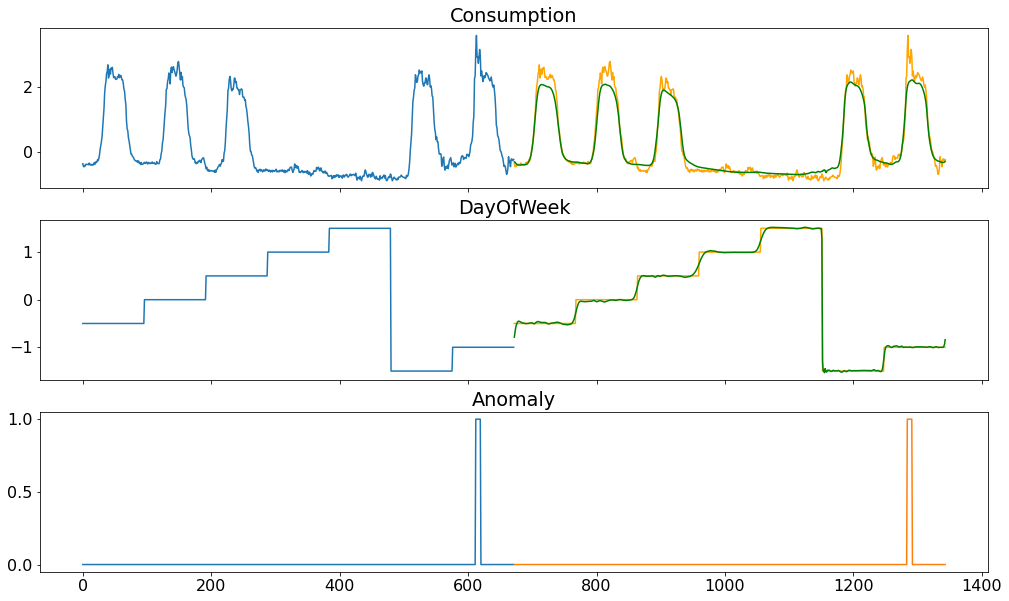

In [32]:
# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(X_test, X_test, A_test, predictions, target_labels, window)

## Computing reconstruction error

In [33]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [34]:
# Non overlapped windows - Training set
X_train_non_overlapped_P1 = build_sequences_reconstruction(X_train_raw_P1, window=window, stride=window)
X_train_non_overlapped_P2 = build_sequences_reconstruction(X_train_raw_P2, window=window, stride=window)
X_train_non_overlapped_P3 = build_sequences_reconstruction(X_train_raw_P3, window=window, stride=window)

X_train_non_overlapped = np.concatenate([X_train_non_overlapped_P1,X_train_non_overlapped_P2],axis=0)
X_train_non_overlapped = np.concatenate([X_train_non_overlapped,X_train_non_overlapped_P3],axis=0)

X_train_non_overlapped.shape

(30, 672, 2)

In [35]:
test_weeks = [0,1,2,3,4,12,17,18,19,39,51] # Weeks that are in the test set
indexes = [0,5,6,9,10] # Considering positions in "text_weeks", indexes of weeks to be considered on alone (non consecutive)
full_seq_index = [] # Tells us which windows of X_Test_Overlapped have to be fully considered (for all the other windows we will consider last "stride" elements)

counter = 0 # Tells us which window of X_Test_Overlapped we're considering

X_test_overlapped = np.empty(shape=(0, 672, 2))

for i in range(len(indexes)): # For all windows to be considered on alone ...
    
    # Interval of consecutive weeks to be considered
    left = indexes[i]
    if i+1 < len(indexes):
        right = indexes[i+1]
    else:
        right = indexes[-1] + 1
    
    full_seq_index.append(counter)
    df = X_test_raw.iloc[(left)*672:(right)*672].copy()
    dataset = build_sequences_reconstruction(df, window, stride) # Creating sequences using consecutive weeks we have identified
    counter = counter + dataset.shape[0]
    X_test_overlapped = np.concatenate((X_test_overlapped, dataset[:,:,:2]), axis=0) # We concatenate new windows created
        
X_test_overlapped.shape, full_seq_index

((1013, 672, 2), [0, 673, 674, 1011, 1012])

In [36]:
# Making predictions on non-overlapped windows of the training set

encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(X_train_non_overlapped)
print(z.shape, c.shape)
train_reconstructions = decoder([z,c])
print(train_reconstructions.shape)

for l in range(M-1):
    encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(X_train_non_overlapped)
    train_prediction = decoder([z,c])
    train_reconstructions = train_prediction + train_reconstructions
    
train_reconstructions = train_reconstructions/M
print(train_reconstructions.shape)

(30, 10) (30, 672, 15)
(30, 672, 2)
(30, 672, 2)


In [37]:
M = 50

In [38]:
# Making predictions on overlapped windows of the test set

test_reconstructions = np.zeros(X_test_overlapped.shape)
print(test_reconstructions.shape)

for i in range(X_test_overlapped.shape[0]):
    
    if(i%100==0): print(i)
    
    _, _, z, _, _, c = encoder(tf.expand_dims(X_test_overlapped[i], axis=0))
    test_reconstructions[i] = decoder([z,c])

    for l in range(M-1):
        _, _, z, _, _, c = encoder(tf.expand_dims(X_test_overlapped[i], axis=0))
        test_prediction = decoder([z,c])
        test_reconstructions[i] = test_prediction + test_reconstructions[i]
    
test_reconstructions = test_reconstructions/M
print(test_reconstructions.shape)

(1013, 672, 2)
0
100
200
300
400
500
600
700
800
900
1000
(1013, 672, 2)


In [39]:
# Function used to plot predictions (reconstructions) made on training data using the model
def inspect_multivariate_prediction_reconstruction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))
        print('Plotting sequence number: ' + str(idx))

    figs, axs = plt.subplots(2, 1, sharex=True, figsize=(17,7))
    for i, col in enumerate(columns[:4]):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

Plotting sequence number: 10


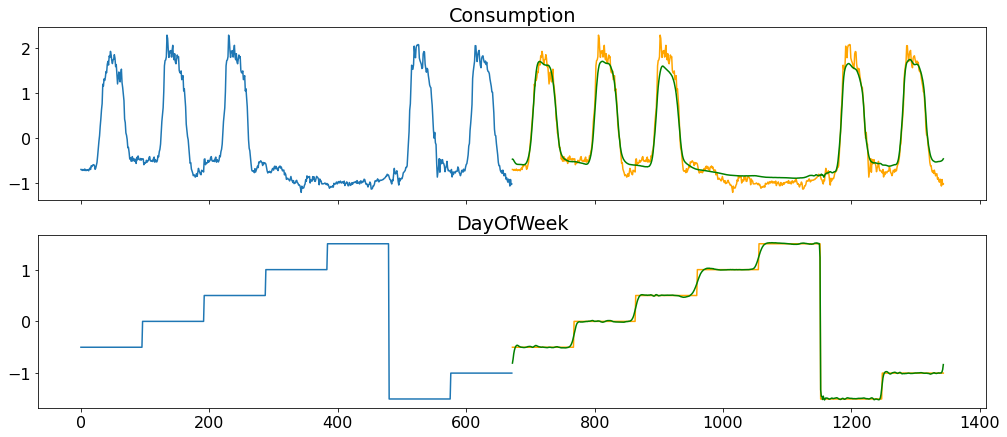

In [40]:
# Plotting reconstructions of the TRAINING set
inspect_multivariate_prediction_reconstruction(X_train_non_overlapped, X_train_non_overlapped, A_train, train_reconstructions, target_labels, window)

In [41]:
# Array that will contain reconstruction errors (floor by floor) - TRAINING SET
reconstruction_errors = np.empty(shape=(0, 1))

# Computing reconstruction errors
for i in range(X_train_non_overlapped.shape[0]):
    error = np.abs(X_train_non_overlapped[i]-train_reconstructions[i])
    error = error[:,:1] # Not interested in the day of the week
    reconstruction_errors = np.concatenate((reconstruction_errors,error), axis=0)
    
mean_error = np.mean(reconstruction_errors, axis = 0) # Mean reconstruction error
std_error = np.std(reconstruction_errors, axis = 0) # Std dev of the reconstruction error
max_error = np.max(reconstruction_errors, axis = 0) # Max error on the training set
  
print(reconstruction_errors.shape) # 34944 = 52 weeks * 672 samples/week
print(mean_error)
print(std_error)
print(max_error)

(20160, 1)
[0.13182777]
[0.11531678]
[1.02920818]


In [42]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_errors, error_threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=(X_test_raw.shape[0]))
    
    i = 0
    for seq in reconstruction_errors:
        for sample in seq: 
            epsilon = sample - error_threshold # We check if the reconstruction error is greater than the threshold
            if epsilon > 0:
                anomaly_predicted[i] = 1
            i = i+1

    return anomaly_predicted

In [43]:
# Array that will contain reconstruction errors (floor by floor) - TEST SET

reconstruction_test = np.empty(shape=(0, 1)) # Predictions made on the test set using the model
reconstruction_errors_test = np.empty(shape=(0, 1)) # Errors made in predicting the test set

for i in range(X_test_overlapped.shape[0]):
    if i in full_seq_index: # Windows to be entirely considered
        error = np.abs(X_test_overlapped[i]-test_reconstructions[i])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,:,:1]), axis=0)
    else: # Windows for which we have to consider only last "stride" elements
        error = np.abs(X_test_overlapped[i,-stride:,:]-test_reconstructions[i,-stride:,:])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,-stride:,:1]), axis=0)
                                        
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

(7392, 1)
(7392, 1)


In [44]:
# Grid search threshold parameters

range_of_val = [x for x in np.arange(5, 15, 0.05)]
best_val = 0
F1_MAX = 0

for i in range_of_val:
    threshold_error_mean_std_TEMP = 0
    threshold_error_mean_std_TEMP = mean_error + i*std_error # mean + n*std_dev
    anomaly_predicted_mean_std_TEMP = 0
    anomaly_predicted_mean_std_TEMP = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std_TEMP)
    f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted_mean_std_TEMP)
    if(f1>F1_MAX):
        F1_MAX = f1
        best_val = i
        print("best threshold parameters: " + str(best_val) + " best f1: " + str(F1_MAX))
            
threshold_error_mean_std = mean_error + best_val*std_error # mean + n*std_dev
anomaly_predicted_mean_std = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std)
                
threshold_error_max = max_error # Max error on the training set
anomaly_predicted_max = predict_anomalies(reconstruction_errors_test, threshold_error_max)

anomaly_predicted_mean_std.sum(), anomaly_predicted_max.sum(), anomaly_predicted_mean_std.shape, anomaly_predicted_max.shape, threshold_error_mean_std, threshold_error_max

best threshold parameters: 5.0 best f1: 0.8517647058823529
best threshold parameters: 5.05 best f1: 0.8547815820543093
best threshold parameters: 5.1499999999999995 best f1: 0.8574821852731591
best threshold parameters: 5.199999999999999 best f1: 0.8585017835909632
best threshold parameters: 5.299999999999999 best f1: 0.8595238095238096
best threshold parameters: 5.349999999999999 best f1: 0.8622754491017963
best threshold parameters: 5.399999999999999 best f1: 0.8640192539109508
best threshold parameters: 5.449999999999998 best f1: 0.8661037394451145
best threshold parameters: 5.499999999999998 best f1: 0.8692493946731235
best threshold parameters: 5.549999999999998 best f1: 0.8734793187347932
best threshold parameters: 5.599999999999998 best f1: 0.8753056234718827
best threshold parameters: 5.6999999999999975 best f1: 0.8760736196319019
best threshold parameters: 5.749999999999997 best f1: 0.8793103448275862
best threshold parameters: 5.799999999999997 best f1: 0.8814814814814815
bes

(379.0, 378.0, (7392,), (7392,), array([1.019767]), array([1.02920818]))

In [45]:
padding_len = (len(X_test_raw)-window)%stride
size = X_test_raw.shape[0]-padding_len
X_test_raw = X_test_raw[:size]

In [46]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)

In [47]:
# Adding ptdictions and predicted anomalies to X_test_raw
X_test_raw['Reconstr'] = reconstruction_test[:,0] # Prediction on floor 1
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted_Mean_Std'] = anomaly_predicted_mean_std[:X_test_raw.shape[0]] # Anomalies predicted using mean and std dev
X_test_raw['Anomaly_Predicted_Max'] = anomaly_predicted_max[:X_test_raw.shape[0]] # Anomalies predicted using max error on the training set
X_test_raw['Error'] = reconstruction_errors_test[:,0] # Prediction error on floor 1
X_test_raw.head()

import datetime as dt

X = np.array(X_test_raw.iloc[:672][['Consumption']])
predictions = np.array(X_test_raw.iloc[:672][['Reconstr']])
anomaly_true = X_test_raw.iloc[:672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[:672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[:672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[:672]['Error']

In [48]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [49]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted_mean_std, a_predicted_max, pred, columns, error_1F): 
   
    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:1]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange') 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), pred[:,i], color='green') 
        axs[i].set_title(col) 
        
    axs[1].plot(np.arange(len(X[:,i])), error_1F) 
    axs[1].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_1F) 
    axs[1].set_title('error') 
            
    axs[2].plot(np.arange(len(X[:,i])), a_true) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[2].set_title('Anomaly_True') 
    
    axs[3].plot(np.arange(len(X[:,i])), a_predicted_mean_std) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_mean_std) 
    axs[3].set_title('Anomaly_Predicted_Mean_Std_Dev')
    
    axs[4].plot(np.arange(len(X[:,i])), a_predicted_max) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_max) 
    axs[4].set_title('Anomaly_Predicted_Max') 
    plt.show()

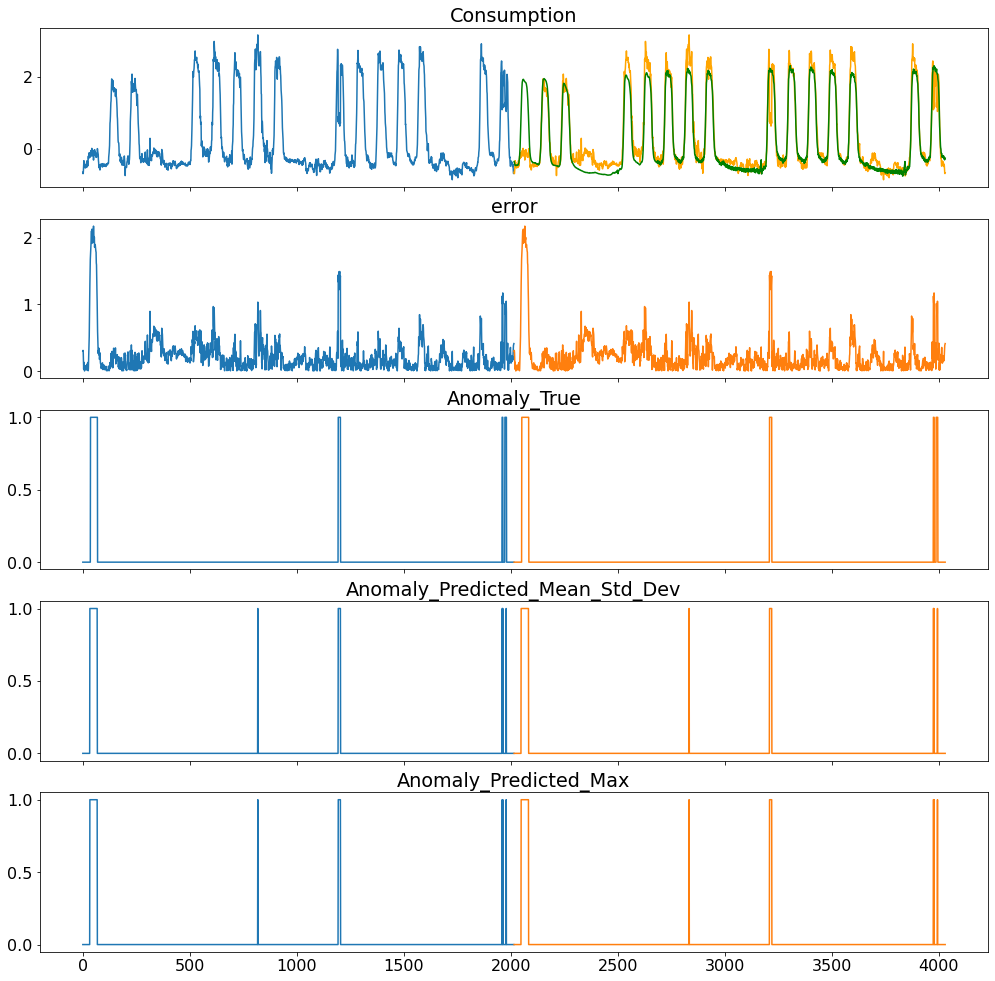

In [50]:
import datetime as dt

i=0
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
predictions = np.array(X_test_raw.iloc[i*672:j*672][['Reconstr']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[i*672:j*672]['Error']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F) # X = ABB_print

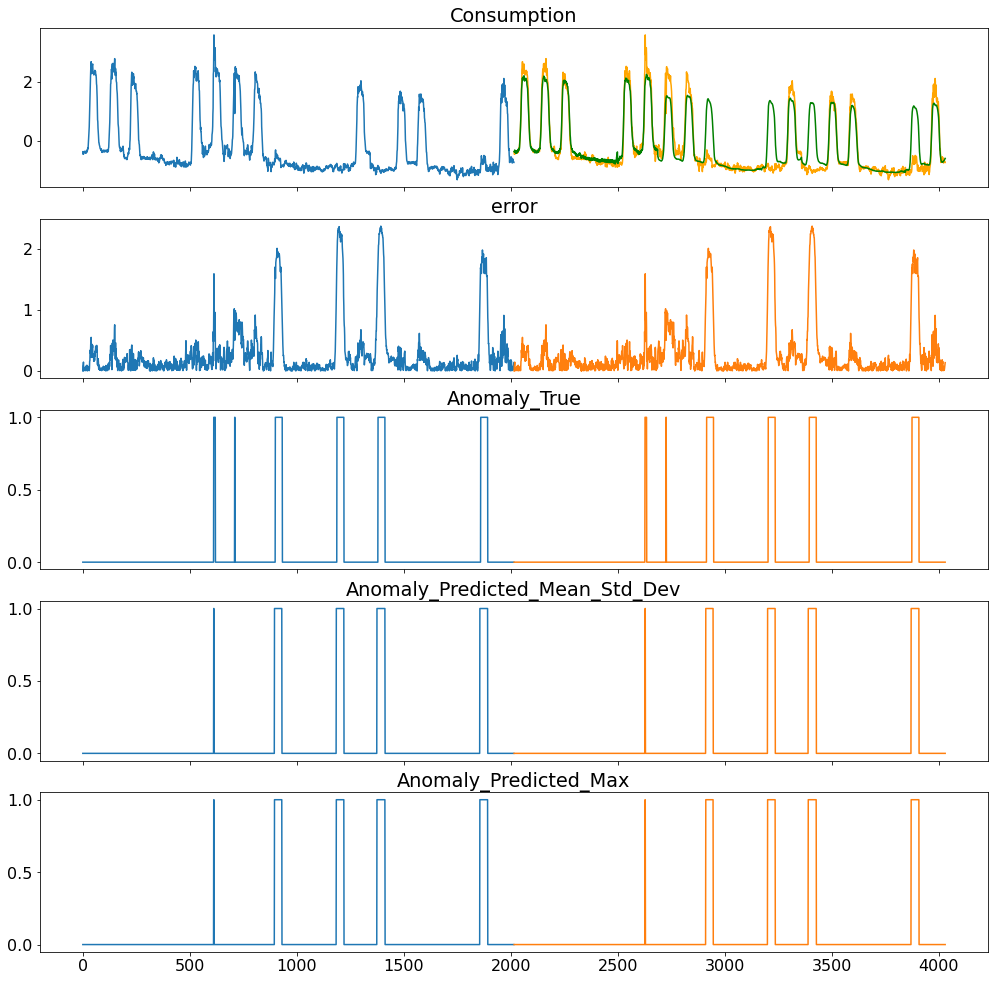

In [51]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
predictions = np.array(X_test_raw.iloc[i*672:j*672][['Reconstr']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[i*672:j*672]['Error']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F) # X = ABB_print

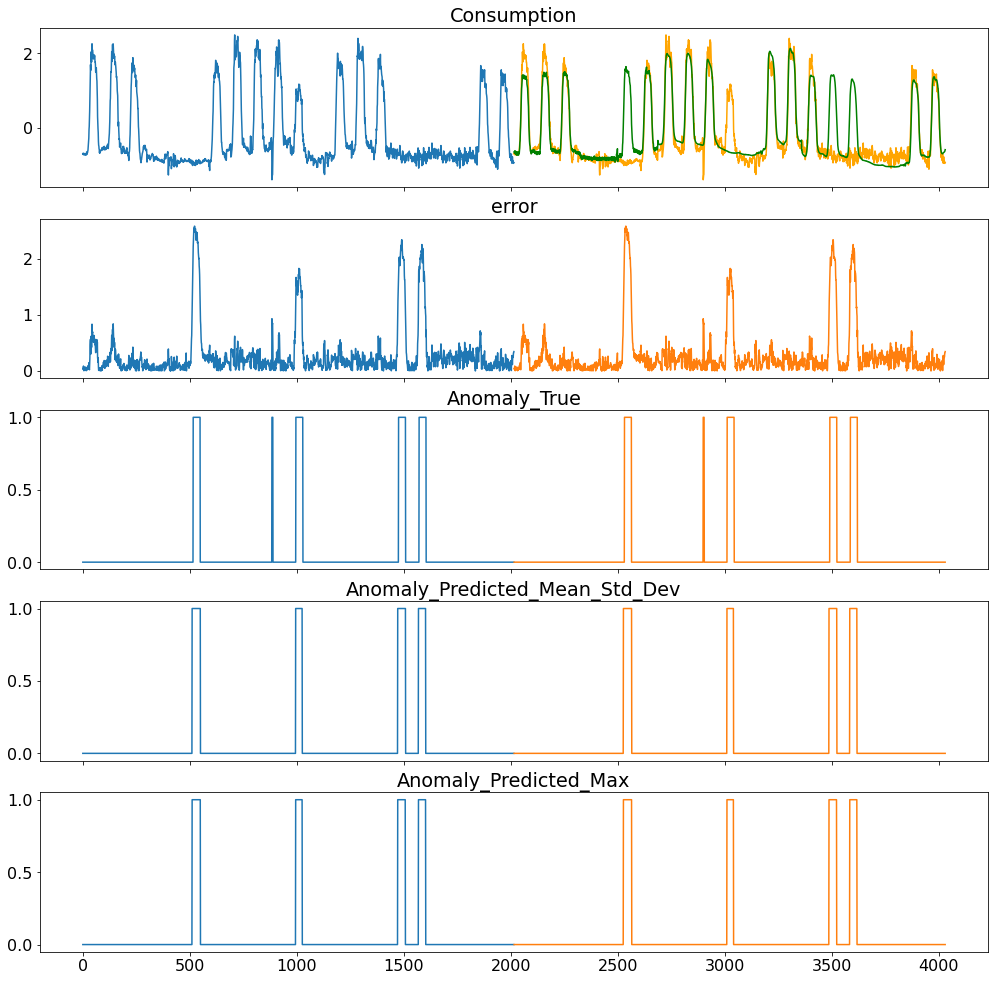

In [52]:
import datetime as dt

i=8
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
predictions = np.array(X_test_raw.iloc[i*672:j*672][['Reconstr']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[i*672:j*672]['Error']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F) # X = ABB_print

Accuracy: 0.9905
Precision: 0.8971
Recall: 0.9164
F1: 0.9067


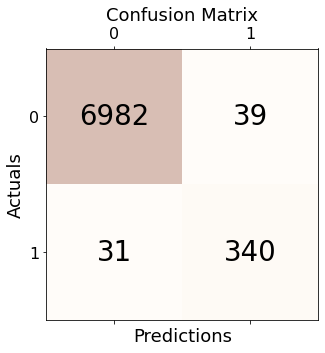

In [53]:
anomaly_predicted = anomaly_predicted_mean_std

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()